## Examples

import cubedsphere and other helper packages

In [1]:
import numpy as np
import cubedsphere as cs

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cartopy.crs as ccrs  # optional, only needed for nicer projections

Specify folder of simulationdata

In [2]:
outdir_ascii = "/Volumes/EXTERN/Simulations/exorad/new_run/paper_runs/WASP-43b/run/"

### Standard conservative regridding

Load data and regrid data

In [3]:
# open Dataset using xmitgcm (see docs for xmitgcm.open_mdsdataset for more details)
ds_ascii, grid = cs.open_ascii_dataset(outdir_ascii, iters=[41472000], prefix = ["T","U","V","W"])
# regrid dataset
regrid = cs.Regridder(ds_ascii, grid)
ds = regrid()
# (optional) converts wind, temperature and stuff
ds = cs.exorad_postprocessing(ds, outdir=outdir_ascii)

time needed to build regridder: 0.9600319862365723
Regridder will use conservative method


Minimal working example of a plot:

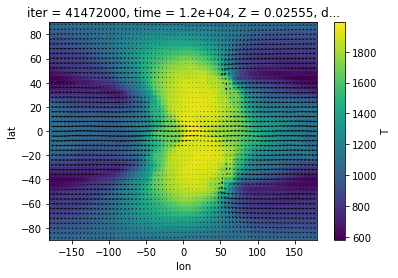

In [4]:
plt.figure()
# Select horizontal slice at latest time:
data = ds.isel(time=-1,Z=-20)
# Plot temperature:
data.T.plot()
# Overplot winds:
cs.overplot_wind(ds, data.U.values, data.V.values)
plt.show()

A littlebit nicer with cartopy:

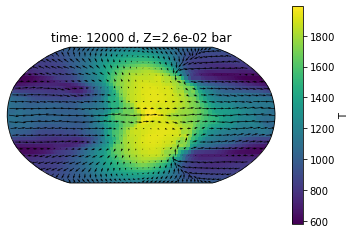

In [5]:
plt.figure()
ax = plt.axes(projection=ccrs.Robinson())
# Plot temperature:
data.T.plot(transform = ccrs.PlateCarree(), ax=ax)
# Overplot winds:
cs.overplot_wind(ds, data.U.values, data.V.values, ax=ax, transform=ccrs.PlateCarree(), stepsize=2)
ax.set_title('time: {:.0f} d, Z={:.1e} bar'.format(data.time.values,data.Z.values))
plt.show()

Utilizing the cubedsphere plot to do a comparison with the original (not regridded) data:

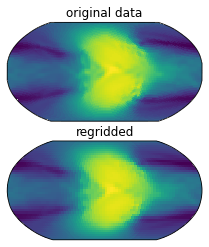

In [6]:
data_orig = ds_ascii.isel(time=-1,Z=-20)

fig, ax = plt.subplots(2,1, subplot_kw={"projection":ccrs.Robinson()})

# Do the plots
cs.plotCS(data_orig.T, data_orig, transform=ccrs.PlateCarree(), ax = ax[0])
ax[1].pcolormesh(data.lon, data.lat, data.T, transform = ccrs.PlateCarree())

ax[0].set_title('original data')
ax[1].set_title('regridded')

plt.show()

### Zonal mean plots

For convenience, we will show an easy way on how to create a zonal mean wind plot

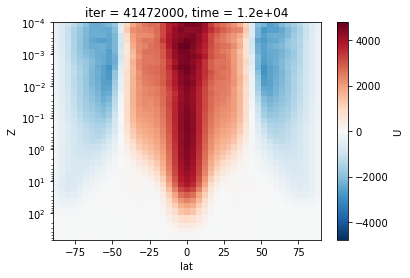

In [7]:
plt.figure()
zmean = ds.U.isel(time=-1).mean(dim='lon')
zmean.plot()
plt.yscale('log')
plt.ylim([700,1e-4])
plt.show()

### From lon,lat to cubedsphere

We are now going to perform a second regridding (from already regridded original to cubedsphere)

In [8]:
# Add some info to the regridded dataset
reg_grid = regrid._build_output_grid(5, 4)
ds["lon_b"] = reg_grid["lon_b"]
ds["lat_b"] = reg_grid["lat_b"]

# Perform back regridding
regrid = cs.Regridder(ds, grid, input_type='ll')
ds_regback = regrid()

time needed to build regridder: 0.9572968482971191
Regridder will use conservative method


Congratulations! `ds_regback` is now again in cubedsphere coordinates!

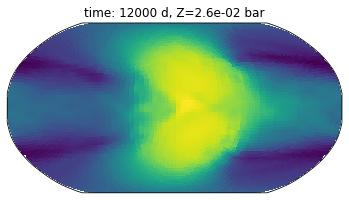

In [9]:
plt.figure()
data_reg_back = ds_regback.isel(time=-1, Z=-20)
ax = plt.axes(projection=ccrs.Robinson())
ax.set_title('time: {:.0f} d, Z={:.1e} bar'.format(data.time.values,data.Z.values))
cs.plotCS(data_reg_back.T, data_reg_back, transform=ccrs.PlateCarree(), ax = ax)
plt.show()

### Calculate global averages

a globally averaged quatity $\bar T$ can be calculated by

$\bar T =\frac{\sum T\cdot\Delta A}{\sum{\Delta A}}$,

where $\Delta A$ is the area of the grid cell.

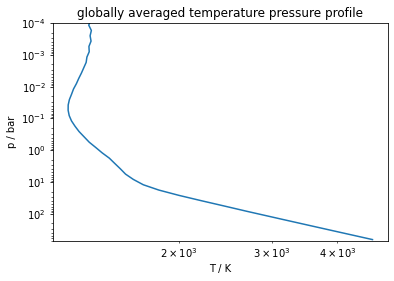

In [10]:
plt.figure()
T_global = (ds.T.isel(time=-1)*ds.area_c).sum(dim=['lon','lat'])/ds.area_c.sum(dim=['lon','lat'])
plt.loglog(T_global, ds.Z)
plt.ylim(700,1e-4)
plt.title('globally averaged temperature pressure profile')
plt.ylabel('p / bar')
plt.xlabel('T / K')
plt.show()

### Open userspecific files

Some packages (e.g., SPARC/MITgcm and exPERT/MITgcm) are not opensource and we therefore need to specify how we have to read the extra output generated by those codes.

This can be easily done using the `extra_variables` keyword, passed to `open_mdsdataset` from `cs.open_ascii_dataset`.

Extra variables can also be added to the codebase of the `cubedsphere` package. You can find already added `exPERT/MITgcm` variables [here](https://github.com/AaronDavidSchneider/cubedsphere/blob/0abe9c7babe25c1d6a6654d2b9cd0f8f8fedf3de/cubedsphere/const.py#L52-L77).

Note: Click [here](https://xmitgcm.readthedocs.io/en/latest/usage.html) to see the options for all `kwargs` used to open datasets with `xmitgcm`.

We will now show an example of how we can load and plot the bolometric emission fluxes generated from the exPERT/MITgcm output.

In [11]:
# Note: Not needed, since already part of cubedsphere package, this is shown only to demonstrate how it works
extra_variables = dict(EXOBFPla=dict(dims=['k_p1', 'j', 'i'],
                                            attrs=dict(standard_name='EXOBFPla', long_name='Bolometric Planetary Flux',
                                                       units='W/m2')))

In [12]:
# open Dataset using xmitgcm (see docs for xmitgcm.open_mdsdataset for more details)
ds_ascii, grid = cs.open_ascii_dataset(outdir_ascii, iters=[41472000], prefix = ["EXOBFPla"], extra_variables=extra_variables)
# regrid dataset
regrid = cs.Regridder(ds_ascii, grid)
ds = regrid()
# (optional) converts wind, temperature and stuff
ds = cs.exorad_postprocessing(ds, outdir=outdir_ascii)

could not rename, got error: cannot rename 'T' because it is not a variable or dimension in this dataset
time needed to build regridder: 0.9598851203918457
Regridder will use conservative method


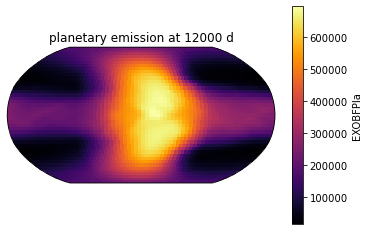

In [13]:
# Plot planetary emission:
plt.figure()
ax = plt.axes(projection=ccrs.Robinson())
ds.EXOBFPla.isel(time=-1, Zp1=-1).plot(transform = ccrs.PlateCarree(), ax=ax, cmap=plt.get_cmap('inferno'))
ax.set_title('planetary emission at {:.0f} d'.format(data.time.values))
plt.show()